# Building an LLM from scratch

Ben Clarkson  
2023-02-10

In [1]:
from typing import Any, Optional, List

import networkx as nx

## LLM from scratch: Automatic Differentiation

I’m building a modern language model with all the bells and whistles
completely from scratch: from vanilla python to functional coding
assistant. Borrowing (shamelessly stealing) from computer games, I’ve
built a tech tree of everything that I think I’ll need to implement to
get a fully functional language model. If you think anything is missing,
[please let me know](mailto:bclarkson-code@proton.me):

<figure>
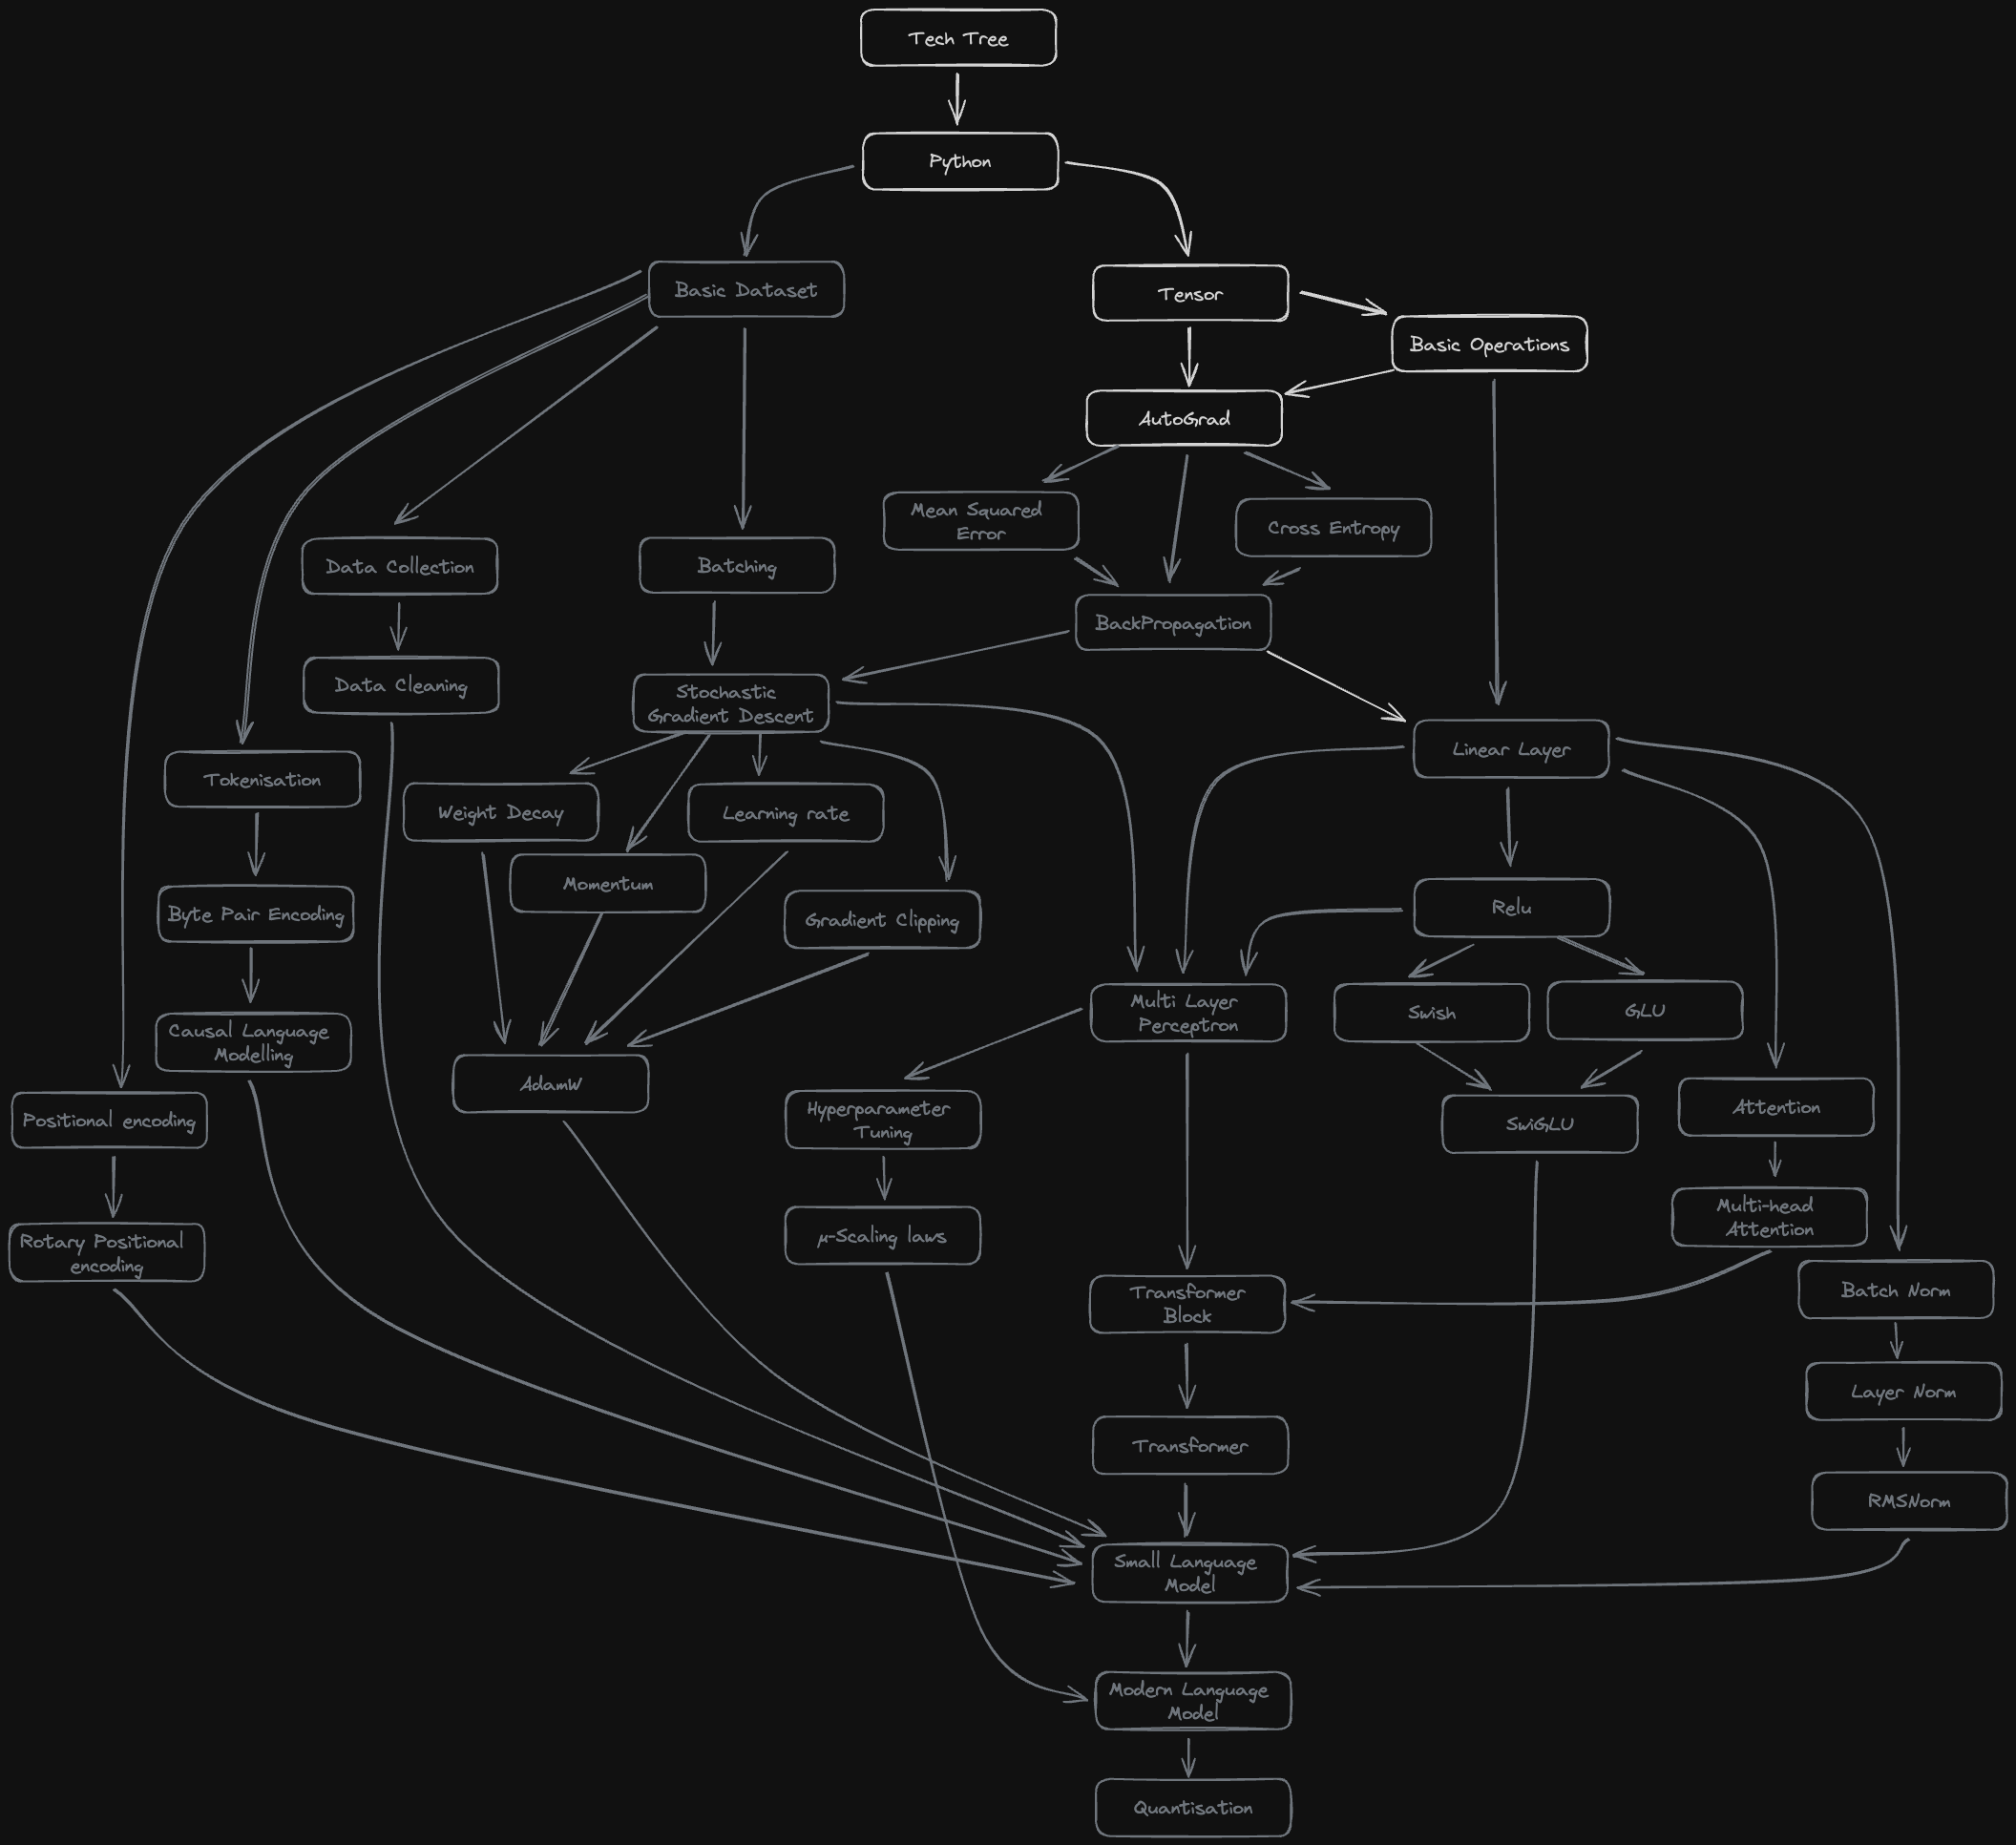
<figcaption aria-hidden="true">The LLM from scratch tech
tree</figcaption>
</figure>

Before we can move onto building modern features like [Rotary Positional
Encodings](https://arxiv.org/abs/2104.09864), we first need to figure
out how to differentiate with a computer. The backpropagation algorithm
that underpins the entire field of Deep Learning requires the ability to
differentiate the outputs of neural networks with respect to (wrt) their
inputs. In this post, we’ll go from nothing to an (admittedly very
limited) automatic differentiation library that can differentiate
arbitrary functions of scalar values.

This one algorithm will form the core of our deep learning library that,
eventually, will include everything we need to train a language model.

## Creating a tensor

We can’t do any differentiation if we don’t have any numbers to
differentiate. We’ll want to add some extra functionality that is in
standard `float` types so we’ll need to create our own. Let’s call it a
`Tensor`.

In [2]:
class Tensor:
    """
    Just a number (for now)
    """

    value: float

    def __init__(self, value: float):
        self.value = value

    def __repr__(self) -> str:
        """
        Create a printable string representation of this
        object

        This function gets called when you pass a Tensor to print

        Without this function:
        >>> print(Tensor(5))
        <__main__.Tensor at 0x104fd1950>

        With this function:
        >>> print(Tensor(5))
        Tensor(5)
        """
        return f"Tensor({self.value})"


# try it out
Tensor(5)

Tensor(5)

Next we’ll need some simple operations we want to perform: addition,
subtraction and multiplication.

In [3]:
def _add(a: Tensor, b: Tensor):
    """
    Add two tensors
    """
    return Tensor(a.value + b.value)


def _sub(a: Tensor, b: Tensor):
    """
    Subtract tensor b from tensor a
    """
    return Tensor(a.value - b.value)


def _mul(a: Tensor, b: Tensor):
    """
    Multiply two tensors
    """
    return Tensor(a.value * b.value)

We can use use our operations as follows:

In [4]:
def test(got: Any, want: Any):
    """
    Check that two objects are equal to each other
    """
    indicator = "✅" if want == got else "❌"
    print(f"{indicator} - Want: {want}, Got: {got}")


a = Tensor(3)
b = Tensor(4)


test(_add(a, b).value, 7)
test(_sub(a, b).value, -1)
test(_mul(a, b).value, 12)

✅ - Want: 7, Got: 7
✅ - Want: -1, Got: -1
✅ - Want: 12, Got: 12

## Scalar derivatives

Diving straight into differentiating matrices sounds too hard so let’s
start with something simpler: differentiating scalars. The simplest
scalar derivative I can think of is differentiating a tensor with
respect to itself: $$\frac{dx}{dx} = 1$$

A more interesting case is the derivative of two tensors added together
(note we are using partial derivatives because our function has multiple
inputs): $$f(x, y) = x + y$$ $$\frac{\partial f}{\partial x} = 1$$
$$\frac{\partial f}{\partial y} = 1$$

We can do a similar thing for multiplication and subtraction

| $f(x, y)$    | $\frac{\partial f}{\partial x}$ | $\frac{\partial f}{\partial y}$ |
|------------------------|------------------------|------------------------|
| $x + y$      | $1$                             | $1$                             |
| $x - y$      | $1$                             | $-1$                            |
| $x \times y$ | $y$                             | $x$                             |

Now that we’ve worked out these derivatives mathematically, the next
step is to convert them into code. In the table above, when we make a
tensor by combining two tensors with an operation, the derivative only
ever depends on the inputs and the operation. There is no “hidden
state”.

This means that the only information we need to store is the inputs to
an operation and a function to calculate the derivative wrt each input.
With this, we should be able to differentiate any binary function wrt
its inputs. A good place to store this information is in the tensor that
is produced by the operation.

We’ll add some new attributes to our `Tensor`: `args` and
`local_derivatives`. If the tensor is the output of an operation, then
`args` will store the arguments to the operation and `local_derivatives`
will store the derivatives wrt each input. We’re calling it
`local_derivatives` to avoid confusion when we start nesting functions.

Once we’ve calculated the derivative (from our `args` and
`local_derivatives`) we’ll need to store it. It turns out that the
neatest place to put this is in the tensor that the output is being
differentiated wrt. We’ll call this `derivative`.

In [5]:
class Tensor:
    """
    A number that can be differentiated
    """

    # If the tensor was made by an operation, the operation arguments
    # are stored in args
    args: tuple["Tensor"] = ()
    # If the tensor was made by an operation, the derivatives wrt
    # operation inputs are stored in derivatives
    local_derivatives: tuple["Tensor"] = ()
    # The derivative we have calculated
    derivative: Optional["Tensor"] = None

    def __init__(self, value: float):
        self.value = value

    def __repr__(self) -> str:
        """
        Create a printable string representation of this
        object

        This function gets called when you pass a Tensor to print

        Without this function:
        >>> print(Tensor(5))
        <__main__.Tensor at 0x104fd1950>

        With this function:
        >>> print(Tensor(5))
        Tensor(5)
        """
        return f"Tensor({self.value})"

For example, if we have

In [6]:
a = Tensor(3)
b = Tensor(4)

output = _mul(a, b)

Then `output.args` and `output.local_derivatives` should be set to:

``` python
output.args == (Tensor(3), Tensor(4))
output.derivatives == (
    b,  # derivative of output wrt a is b
    a,  # derivative of output wrt b is a
)
```

Once we have actually computed the derivatives, then the derivative of
`output` wrt `a` will be stored in `a.derivative` and should be equal to
`b` (which is 4 in this case).

We know that we’ve done everything right once these tests pass:

In [7]:
a = Tensor(3)
b = Tensor(4)

output = _mul(a, b)

# TODO: differentiate here

test(got=output.args, want=(a, b))
test(got=output.local_derivatives, want=(b, a))
test(got=a.derivative, want=b)
test(got=b.derivative, want=a)

❌ - Want: (Tensor(3), Tensor(4)), Got: ()
❌ - Want: (Tensor(4), Tensor(3)), Got: ()
❌ - Want: Tensor(4), Got: None
❌ - Want: Tensor(3), Got: None

First, let’s add a function to our `Tensor` that will actually calculate
the derivatives for each of the function arguments. Pytorch calls this
function `backward` so we’ll do the same.

In [8]:
class Tensor:
    """
    A number that can be differentiated
    """

    # If the tensor was made by an operation, the operation arguments
    # are stored in args
    args: tuple["Tensor"] = ()
    # If the tensor was made by an operation, the derivatives wrt
    # operation inputs are stored in
    local_derivatives: tuple["Tensor"] = ()
    # The derivative we have calculated
    derivative: Optional["Tensor"] = None

    # optionally give this tensor a name
    name: Optional[str] = None
    # Later, we'll want to record the path we followed to get
    # to this tensor and some operations we did along the way
    # don't worry about these for now
    paths: List[Tensor] = None
    chains: List[Tensor] = None

    def __init__(self, value: float):
        self.value = value

    def backward(self):
        if self.args is None or self.local_derivatives is None:
            raise ValueError(
                "Cannot differentiate a Tensor that is not a function of other Tensors"
            )

        for arg, derivative in zip(self.args, self.local_derivatives):
            arg.derivative = derivative

    def __repr__(self) -> str:
        """
        Create a printable string representation of this
        object

        This function gets called when you pass a Tensor to print

        Without this function:
        >>> print(Tensor(5))
        <__main__.Tensor at 0x104fd1950>

        With this function:
        >>> print(Tensor(5))
        Tensor(5)
        """
        return f"Tensor({self.value})"

This only works if we also store the arguments and derivatives in the
output tensors of operations

In [9]:
def _add(a: Tensor, b: Tensor):
    """
    Add two tensors
    """
    result = Tensor(a.value + b.value)
    result.local_derivatives = (Tensor(1), Tensor(1))
    result.args = (a, b)
    return result


def _sub(a: Tensor, b: Tensor):
    """
    Subtract tensor b from a
    """
    result = Tensor(a.value - b.value)
    result.local_derivatives = (Tensor(1), Tensor(-1))
    result.args = (a, b)
    return result


def _mul(a: Tensor, b: Tensor):
    """
    Multiply two tensors
    """
    result = Tensor(a.value * b.value)
    result.local_derivatives = (b, a)
    result.args = (a, b)
    return result

Let’s re-run our tests and see if it works

In [10]:
a = Tensor(3)
b = Tensor(4)

output = _mul(a, b)

output.backward()

test(got=output.args, want=(a, b))
test(got=output.local_derivatives, want=(b, a))
test(a.derivative, b)
test(b.derivative, a)

✅ - Want: (Tensor(3), Tensor(4)), Got: (Tensor(3), Tensor(4))
✅ - Want: (Tensor(4), Tensor(3)), Got: (Tensor(4), Tensor(3))
✅ - Want: Tensor(4), Got: Tensor(4)
✅ - Want: Tensor(3), Got: Tensor(3)

So far so good, let’s try nesting operations.

In [11]:
a = Tensor(3)
b = Tensor(4)

output_1 = _mul(a, b)
# z = a + (a * b)
output_2 = _add(a, output_1)

output_2.backward()

# should get
# dz/db = 0 + a = a
test(b.derivative, a)

❌ - Want: Tensor(3), Got: None

Something has gone wrong.

We should have got `a` as the derivative for `b` but we got `0` instead.
Looking through the `.backward()` function, the issue is pretty clear:
we haven’t thought about nested functions. To get this example working,
we’ll need to figure out how to calculate derivatives through multiple
functions instead of just one.

## Chaining Functions Together

To calculate derivatives of nested functions, we can use a rule from
calculus: The Chain Rule.

For a variable $z$ generated by nested functions $f$ and $g$ such that
$$z = f(g(x))$$

Then the derivative of $z$ wrt $x$ is:
$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(x)}{\partial x}$$

Here, $u$ is a dummy variable. $\frac{\partial f(u)}{\partial u}$ means
the derivative of $f$ wrt its input.

For example, if

$$f(x) = g(x)^2$$ Then we can define $u=g(x)$ and rewrite $f$ in terms
of u
$$f(u) = u^2 \implies \frac{\partial f(u)}{\partial u} = 2u = 2 g(x)$$

### Multiple Variables

The chain rule works as you might expect for functions of multiple
variables. When differentiating wrt a variable, we can treat the other
variables as constant and differentiate as normal $$z = f(g(x), h(y))$$

$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(x)}{\partial x}$$
$$\frac{\partial z}{\partial y} = \frac{\partial f(u)}{\partial u} \frac{\partial h(y)}{\partial y}$$

If we have different functions that take the same input, we
differentiate each of them individually and then add them together

$$z = f(g(x), h(x))$$

We get
$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u}\frac{\partial g(x)}{\partial x} + \frac{\partial f(u)}{\partial u}\frac{\partial h(x)}{\partial x}$$

### More than 2 functions

If we chain 3 functions together, we still just multiply the derivatives
for each function together:

$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(x)}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(u)}{\partial u}\frac{\partial h(x)}{\partial x}$$

And this generalises to any amount of nesting

$$z = f_1(f_2(....f_{n-1}(f_n(x))...)) $$
$\implies \frac{\partial z}{\partial x} = \frac{\partial f_1(u)}{\partial u}\frac{\partial f_2(u)}{\partial u}...\frac{\partial f_{n-1}(u)}{\partial u}\frac{\partial f_{n}(x)}{\partial x}$\$

### A picture is worth a thousand equations

As you probably noticed, the maths is starting to get quite dense. When
we start working with neural networks, we can easily get 100s or 1000s
of functions deep so to get a handle on things, we’ll need a different
strategy. Helpfully, there is one: turning it into a graph.

We can start with some rules:

> Variables are represented with circles and operations are represented
> with boxes

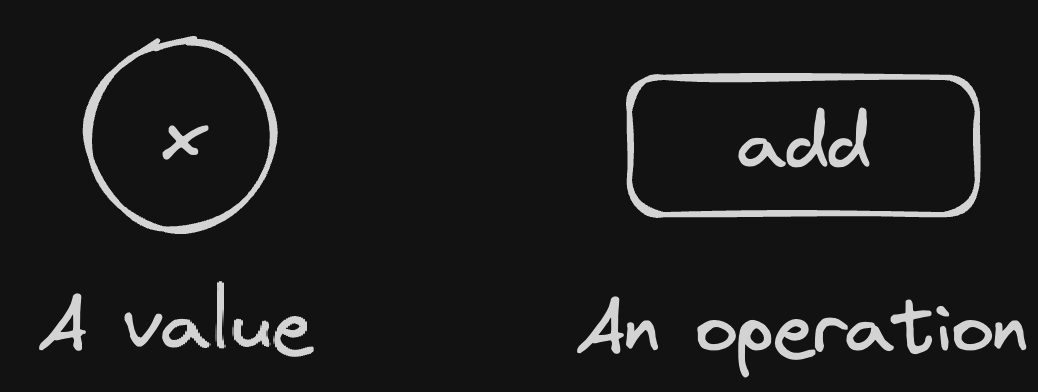

> Inputs to an operation are represented with arrows that point to the
> operation box. Outputs point away.

For example, here is the diagram for $z = mx$

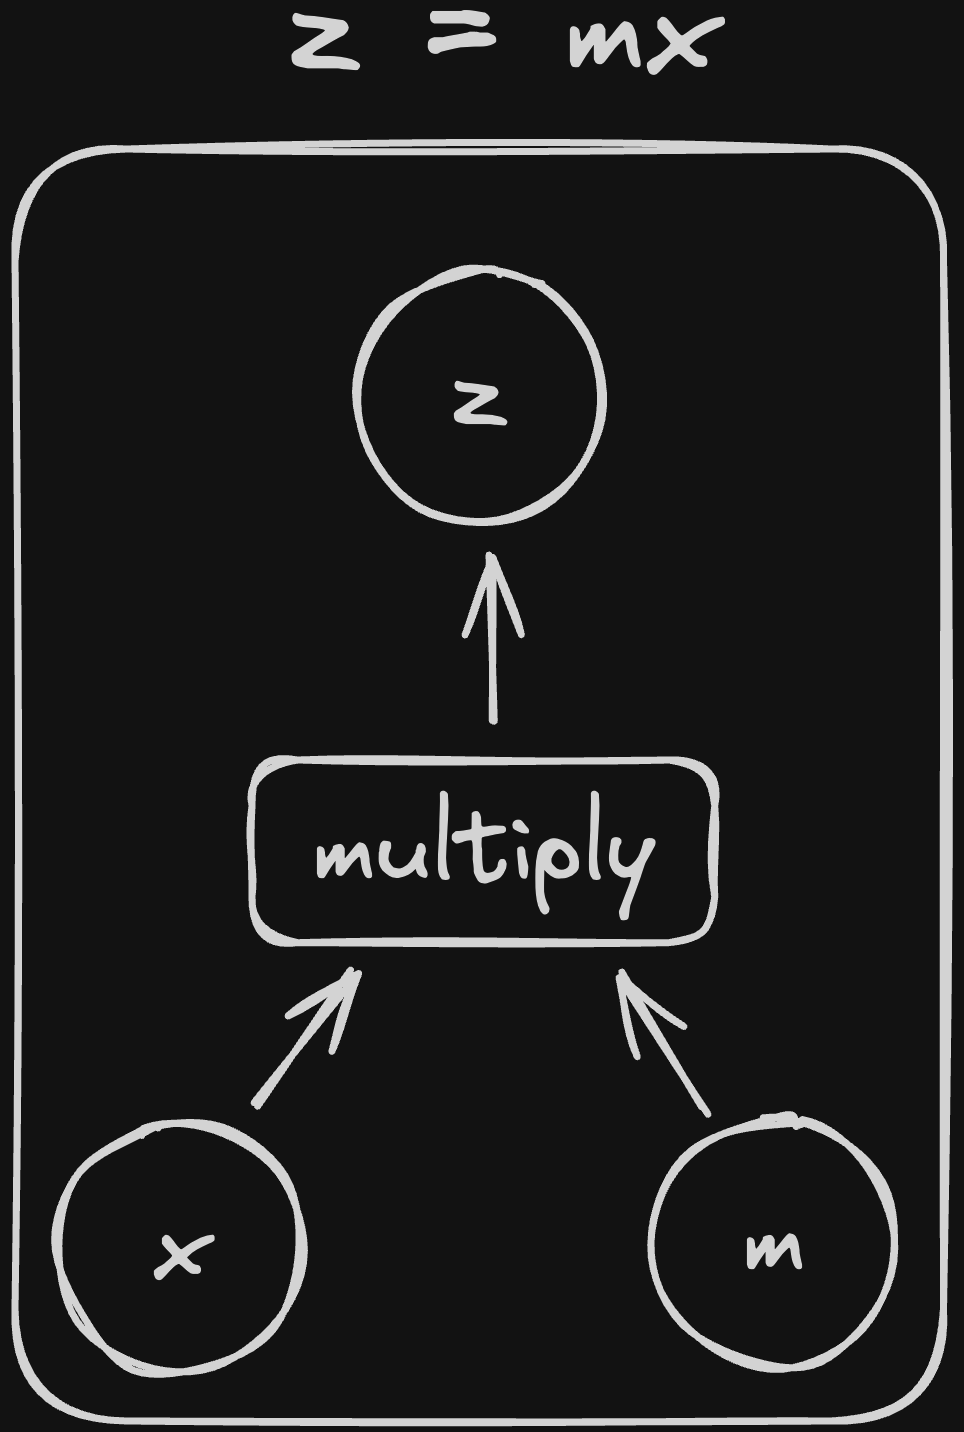

And that’s it! All of the equations we’ll be working with can be
represented graphically using these simple rules. To try it out, let’s
draw the diagram for a more complex formula:

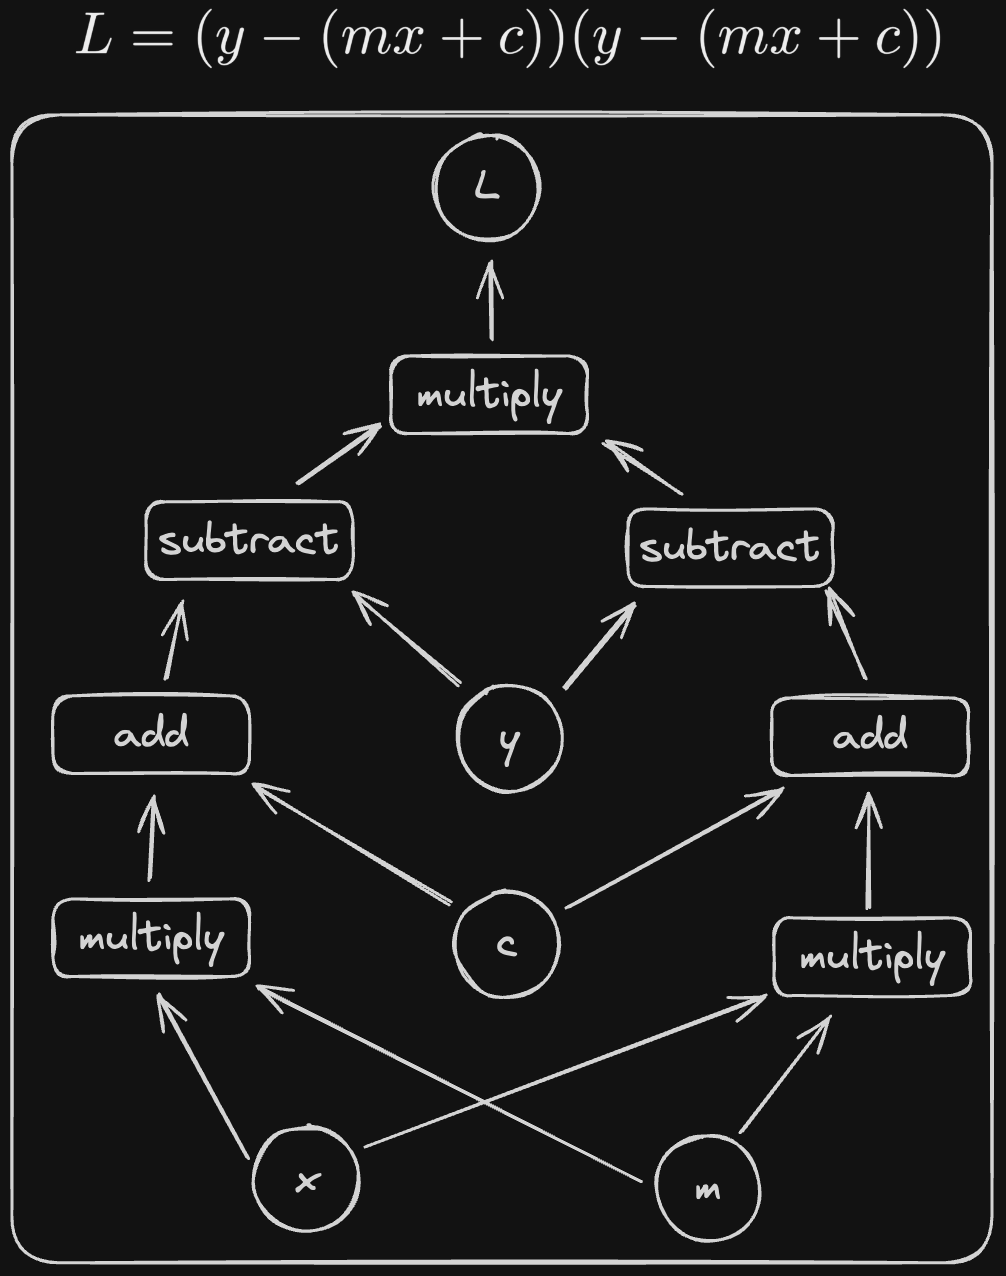

This is an example of a structure called a graph (also called a
network). A lot of problem in computer science get much easier if you
can represent them with a graph and this is no exception.

The real power of these diagrams is that they can also help us with our
derivatives. Take $$y = mx + p = \texttt{add}(p, \texttt{mul}(m ,x)).$$

From before, we can find its derivatives by differentiating each
operation wrt its inputs and multiplying the results together. In this
case, we get:
$$\frac{\partial y}{\partial p} = \frac{\partial \texttt{add}(u_1, u_2)}{\partial u_1} = 1$$
$$\frac{\partial y}{\partial m} = \frac{\partial \texttt{add}(u_1, u_2)}{\partial u_2}\frac{\partial \texttt{mul}(u_1, u_2)}{\partial u_2} = 1 \times x = x$$
$$\frac{\partial y}{\partial x} = \frac{\partial \texttt{add}(u_1, u_2)}{\partial u_2}\frac{\partial \texttt{mul}(u_1, u_2)}{\partial u_1} = 1 \times m = m$$

We can also graph it like this:

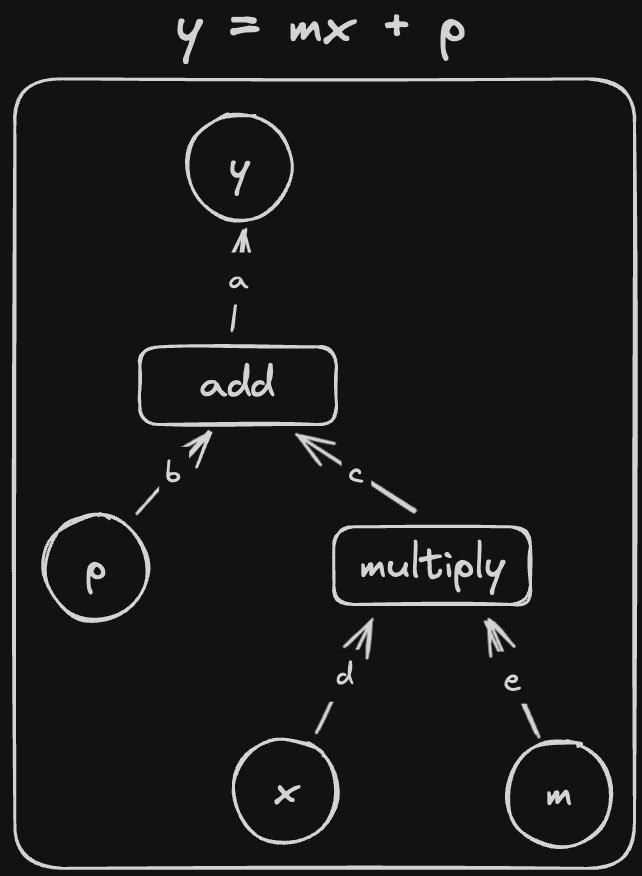

If you imagine walking from $y$ to each of the inputs, you might notice
a similarity between the edges you pass through and the equations above.
If you walk from $y$ to $x$, you’ll pass through `a->c->d`. Similarly,
if you walk from $y$ to $m$, you’ll pass through `a->d->e`. Notice that
both paths go through `c`, the edge coming out of `add` that corresponds
to the input $u_2$. Also, both equations include the term
$\frac{\partial \texttt{add}(u_1, u_2)}{\partial u_2}$.

If I rename the edges as follows:

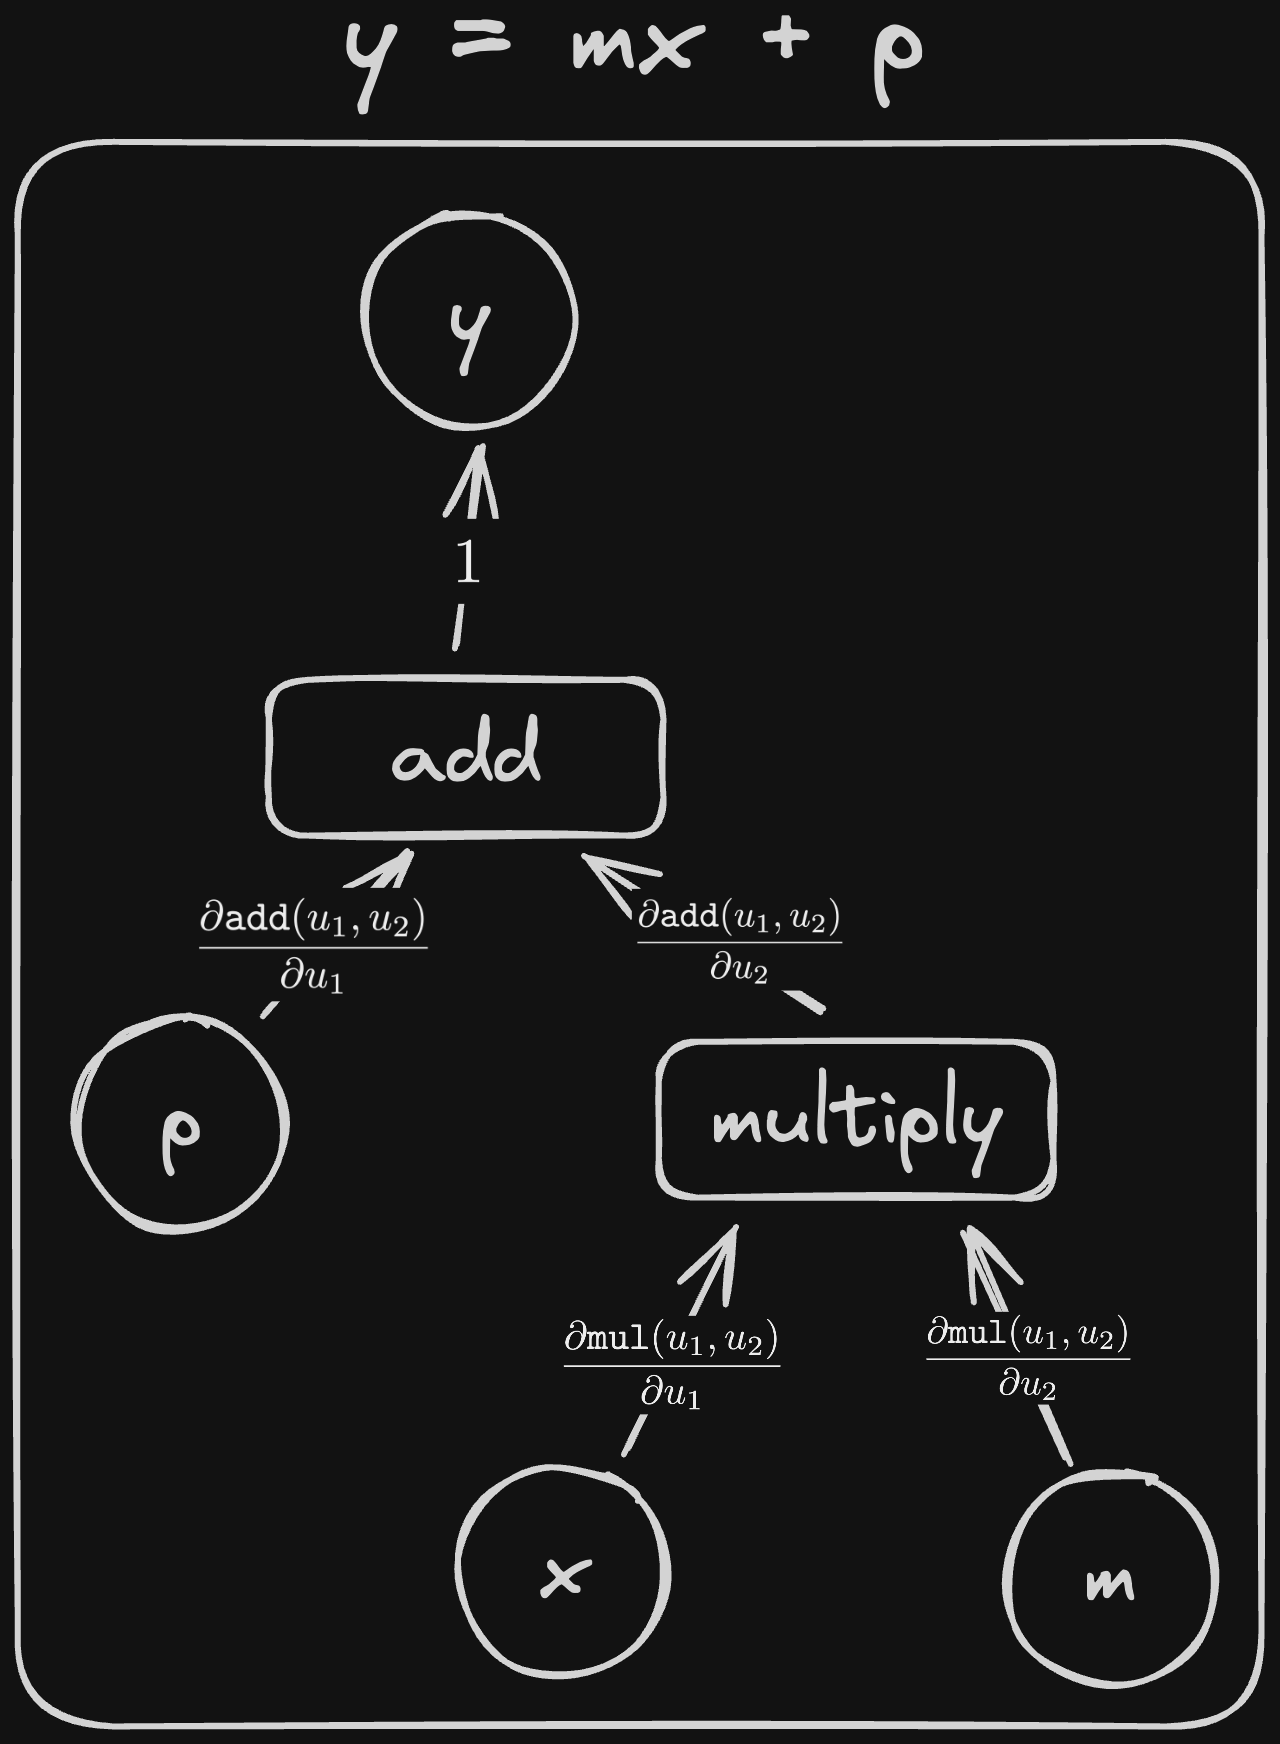

We can see that going from $y$ to $x$, we pass through $1$,
$\frac{\partial \texttt{add}(u_1, u_2)}{\partial u_2}$ and
$\frac{\partial \texttt{mul}(u_1, u_2)}{\partial u_1}$. If we multiply
these together, we get exactly
$\frac{\partial \texttt{add}(u_1, u_2)}{\partial u_2}\frac{\partial \texttt{mul}(u_1, u_2)}{\partial u_1} = \frac{\partial y}{\partial x}$!

It turns out that this rule works in general:

> If we have some operation $\texttt{op}(u_1, u_2, ..., u_n)$, we should
> label the edge corresponding to input $u_i$ with
> $\frac{\partial \texttt{op}(u_1, u_2, ..., u_n)}{\partial u_i}$

Then, if we want to find the derivative of the output node wrt any of
the inputs,

> The derivative of an output variable wrt one of the input variables
> can be found by traversing the graph from the output to the input and
> multiplying together the derivatives for every edge on the path

To cover every edge case, there are some extra details

> If a graph contains multiple paths from the output to an input, then
> the derivative is the sum of the products for each path

This comes from the case we saw earlier where when we have different
functions that have the same input we have to add their derivative
chains together.

> If an edge is not the input to any function, its derivative is 1

This covers the edge that leads from the final operation to the output.
You can think of the edge having the derivative
$\frac{\partial y}{\partial y}=1$

And that’s it! Let’s try it out with $z = (x + c)x$:

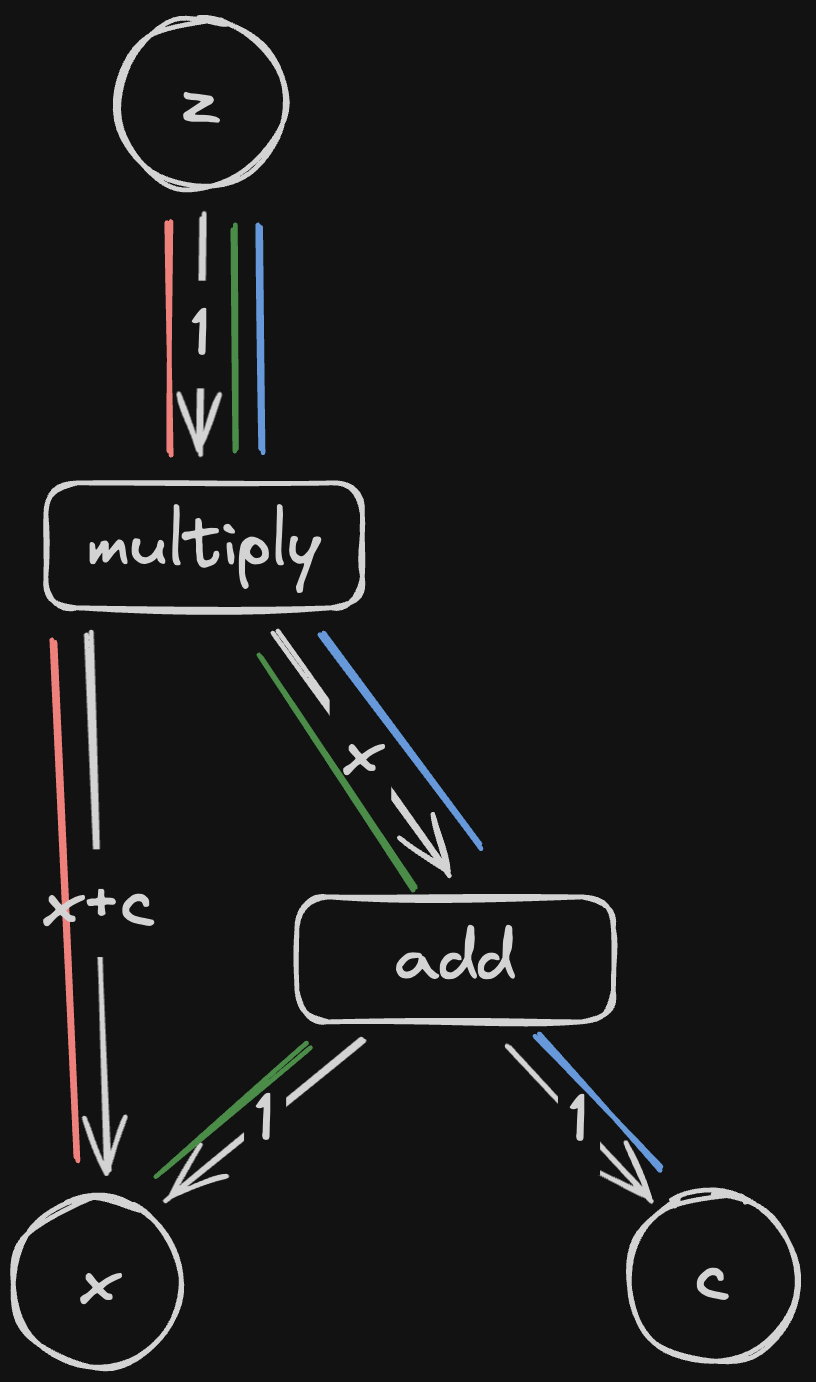

Here, instead of writing the formulae for each derivative, I have gone
ahead and calculated their actual values. Instead of just figuring out
the formulae for a derivative, we want to calculate its value when we
plug in our input parameters.

All that remains is to multiply the local derivatives together along
each path. We’ll call the product of derivatives along a single path a
chain (after the chain rule)

We can get from $z$ to $x$ via the green path and the red path.
Following these paths, we get:
$$\text{red path} = 1 \times (x + c) = x + c$$ Along the green path we
get: $$\text{green path} = 1 \times x \times 1 = x$$

Adding these together, we get $(x+c) + x = 2x + c$

If we work out the derivative algebraically:

$$\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}((x+c)x) = \frac{\partial}{\partial x}(x^2 + cx) = \frac{\partial x^2}{\partial x} + c\frac{\partial x}{\partial x} = 2x + c$$

We can see that it seems to work! Calculating
$\frac{\partial z}{\partial c}$ is left as an exercise for the reader
(I’ve always wanted to say that).

To summarise, we have invented the following algorithm for calculating
of a variable wrt its inputs:

1.  Turn the equation into a graph
2.  Label each edge with the appropriate derivative
3.  Find every path from the output to the input variable you care about
4.  Follow each path and multiply the derivatives you pass through
5.  Add together the results for each path

Now that we have an algorithm in pictures and words, let’s turn it into
code.

### The Algorithm™

Surprisingly, we have actually already converted our functions into
graphs. If you recall, when we generate a tensor from an operation, we
record the inputs to the operation in the output tensor (in `.args`). We
also stored the functions to calculate derivatives for each of the
inputs in `.local_derivatives` which means that we know both the
destination and derivative for every edge that points to a given node.
This means that we’ve already completed steps 1 and 2.

The next challenge is to find all paths from the tensor we want to
differentiate to the input tensors that created it. Because none of our
operations are self referential (outputs are never fed back in as
inputs), and all of our edges have a direction, our graph of operations
is a directed acyclic graph or DAG. The property of the graph having no
cycles means that we can find all paths to every parameter pretty easily
with a Breadth First Search (or Depth First Search but BFS makes some
optimisations easier as we’ll see in part 2).

To try it out, let’s recreate that giant graph we made earlier. We can
do this by first calculating $L$ from the inputs

In [12]:
y = Tensor(1)
m = Tensor(2)
x = Tensor(3)
c = Tensor(4)

# L = (y - (mx + c))^2
left = _sub(y, _add(_mul(m, x), c))
right = _sub(y, _add(_mul(m, x), c))

L = _mul(left, right)

# Attaching names to tensors will make our
# diagram look nicer
y.name = "y"
m.name = "m"
x.name = "x"
c.name = "c"
L.name = "L"

And then using Breadth First Search to do 3 things:

-   Find all nodes
-   Find all edges
-   Find all paths from $L$ to our parameters

We haven’t implemented a simple way to check whether two tensors are
identical so we’ll need to compare hashes.

In [13]:
edges = []

stack = [(L, [L])]

nodes = []
edges = []
while stack:
    node, current_path = stack.pop()
    # Record nodes we haven't seen before
    if hash(node) not in [hash(n) for n in nodes]:
        nodes.append(node)

    # If we have reached a parameter (it has no arguments
    # because it wasn't created by an operation) then
    # record the path taken to get here
    if not node.args:
        if node.paths is None:
            node.paths = []
        node.paths.append(current_path)
        continue

    for arg in node.args:
        stack.append((arg, current_path + [arg]))
        # Record every new edge
        edges.append((hash(node), hash(arg)))

Now we’ve got all of the edges and nodes, we have complete knowledge of
our computational graph. Let’s use networkx to plot it

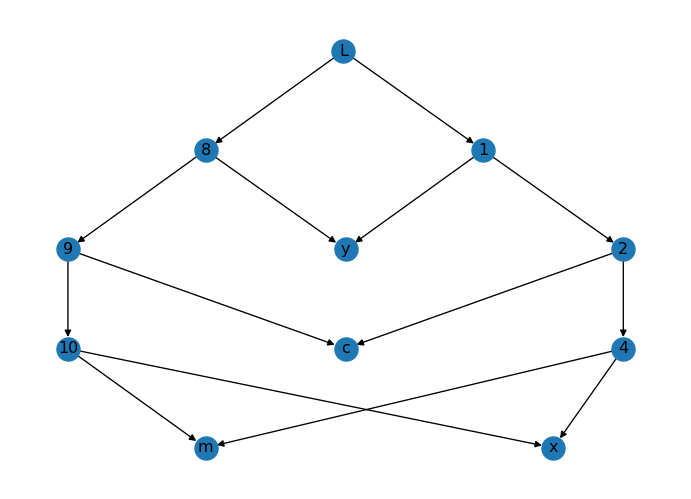

In [14]:
# Assign a unique integer to each
# unnamed node so we know which
# node is which in the picture
labels = {}
for i, node in enumerate(nodes):
    if node.name is None:
        labels[hash(node)] = str(i)
    else:
        labels[hash(node)] = node.name

graph = nx.DiGraph()
graph.add_edges_from(edges)
pos = nx.nx_agraph.pygraphviz_layout(graph, prog="dot")
nx.draw(graph, pos=pos, labels=labels)

If you squint a bit, you can see that this looks like the graph we made
earlier! Let’s take a look at the paths the algorithm found from $L$ to
$x$.

In [15]:
for path in x.paths:
    steps = []
    for step in path:
        steps.append(labels[hash(step)])
    print("->".join(steps))

L->1->2->4->x
L->8->9->10->x

The paths look correct! All we need to do now is to modify the algorithm
a bit to keep track of the chain of derivatives along each path.

In [16]:
y = Tensor(1)
m = Tensor(2)
x = Tensor(3)
c = Tensor(4)

# L = (y - (mx + c))^2
left = _sub(y, _add(_mul(m, x), c))
right = _sub(y, _add(_mul(m, x), c))

L = _mul(left, right)

y.name = "y"
m.name = "m"
x.name = "x"
c.name = "c"
L.name = "L"

In [17]:
stack = [(L, [L], [])]

nodes = []
edges = []
while stack:
    node, current_path, current_chain = stack.pop()
    # Record nodes we haven't seen before
    if hash(node) not in [hash(n) for n in nodes]:
        nodes.append(node)

    # If we have reached a parameter (it has no arguments
    # because it wasn't created by an operation) then
    # record the path taken to get here
    if not node.args:
        if node.paths is None:
            node.paths = []
        if node.chains is None:
            node.chains = []
        node.paths.append(current_path)
        node.chains.append(current_chain)
        continue

    for arg, op in zip(node.args, node.local_derivatives):
        next_node = arg
        next_path = current_path + [arg]
        next_chain = current_chain + [op]

        stack.append((arg, next_path, next_chain))

        # Record every new edge
        edges.append((hash(node), hash(arg)))

Let’s check if the derivatives were recorded correctly.

In [18]:
print(f"Number of chains: {len(x.chains)}")
for chain in x.chains:
    print(chain)

Number of chains: 2
[Tensor(-9), Tensor(-1), Tensor(1), Tensor(2)]
[Tensor(-9), Tensor(-1), Tensor(1), Tensor(2)]

Looks reasonable so far. We have 2 identical paths, each with 4
derivatives (one for each edge in the path) as expected.

Let’s multiply the derivatives together along each path and add the
total for each path together and see if we get the right answer.

According my calculations (and [Wolfram
Alpha](https://www.wolframalpha.com/)) the derivative of $L$ wrt $x$ is:
$$\frac{\partial L}{\partial x} = 2m (c + mx - y)$$ Plugging the values
for our tensors in, we get $$2\times2 (4 + (2\times3) - 1) = 36$$

In [19]:
total_derivative = Tensor(0)
for chain in x.chains:
    chain_total = Tensor(1)
    for step in chain:
        chain_total = _mul(chain_total, step)
    total_derivative = _add(total_derivative, chain_total)

total_derivative

Tensor(36)

The correct answer! It looks like our algorithm works. All that remains
is to put all the pieces together.

## Putting it all together

When dreaming up the algorithm, we kept a record of the nodes, edges and
paths which made plotting and debugging easier. Now that we know that it
works, we can remove these and simplify things a bit.

In [20]:
def backward(root_node: Tensor) -> None:
    stack = [(root_node, [])]

    while stack:
        node, current_derivative = stack.pop()

        # if we have reached a parameter (it has no arguments
        # because it wasn't created by an operation) then
        # record the path taken to get here
        if not node.args:
            if node.chains is None:
                node.chains = []
            node.chain.append(current_derivative)
            continue

        for arg, op in zip(node.args, node.local_derivatives):
            stack.append((arg, current_derivative + [op]))

There is also no need (for now) to store the derivatives and calculate
them separately. Instead, we can avoid a bunch of repeated calculations
by multiplying the derivatives as we go.

In [21]:
def backward(root_node: Tensor) -> None:
    stack = [(root_node, Tensor(1))]

    while stack:
        node, current_derivative = stack.pop()

        # if we have reached a parameter (it has no arguments
        # because it wasn't created by an operation) then add the
        # derivative
        if not node.args:
            if node.derivative is None:
                node.derivative = current_derivative
            else:
                node.derivative = _add(node.derivative, current_derivative)
            continue

        for arg, derivative in zip(node.args, node.local_derivatives):
            stack.append((arg, _mul(current_derivative, derivative)))

Let’s make sure we didn’t break anything

In [22]:
y = Tensor(1)
m = Tensor(2)
x = Tensor(3)
c = Tensor(4)

left = _sub(y, _add(_mul(m, x), c))
right = _sub(y, _add(_mul(m, x), c))

L = _mul(left, right)
backward(L)

print(f"{x.derivative = }\n")
test(got=x.derivative.value, want=36)

x.derivative = Tensor(36)

✅ - Want: 36, Got: 36

Let’s put this algorithm into our Tensor object

In [23]:
class Tensor:
    """
    A float that can be differentiated
    """

    args: tuple[Tensor] = ()
    local_derivatives: tuple[Tensor] = ()
    # The derivative (once we've calculated it).  This is None if the derivative
    # has not been computed yet
    derivative: Tensor | None = None

    def __init__(self, value: float):
        self.value = value

    def __repr__(self) -> str:
        return f"Tensor({self.value.__repr__()})"

    def backward(self):
        if self.args is None or self.local_derivatives is None:
            raise ValueError(
                "Cannot differentiate a Tensor that is not a function of other Tensors"
            )

        stack = [(self, Tensor(1))]

        while stack:
            node, current_derivative = stack.pop()

            # if we have reached a parameter (it has no arguments
            # because it wasn't created by an operation) then add the
            # derivative
            if not node.args:
                if node.derivative is None:
                    node.derivative = Tensor(0)
                node.derivative = _add(node.derivative, current_derivative)
                continue

            for arg, derivative in zip(node.args, node.local_derivatives):
                new_derivative = _mul(current_derivative, derivative)
                stack.append((arg, new_derivative))

Let’s try it out

In [24]:
y = Tensor(1)
m = Tensor(2)
x = Tensor(3)
c = Tensor(4)

left = _sub(y, _add(_mul(m, x), c))
right = _sub(y, _add(_mul(m, x), c))

L = _mul(left, right)
L.backward()

test(x.derivative, Tensor(36))

❌ - Want: Tensor(36), Got: Tensor(36)

Huh?

By default, if you compare two objects in python with `==`, python will
check whether the object on the left has the same reference as the
object as the one on the right. Because `Tensor(36)` is a different
object (that just happens to have the same value) to `x.derivative`,
`x.derivative == Tensor(36)` returns `False`.

It makes a lot more sense to compare two tensors based upon their
`.value`. To achieve this, we can add the `__eq__` special method to
`Tensor` which will change the behaviour of the `==` operator for
`Tensor` objects

In [25]:
def __eq__(self, other) -> bool:
    """
    Tells python to compare .value when applying the `==`
    operation to two tensors instead of comparing references
    """
    if not isinstance(other, "Tensor"):
        raise TypeError(f"Cannot compare a Tensor with a {type(other)}")

    return self.value == other.value

Similarly, if we try to use `+`, `-` or `*` on our tensors, we’ll get an
error. We can tell python how to do these operations on our tensors by
defining the following special functions:

-   `__add__` let’s us use `+`
-   `__sub__` let’s us use `-`
-   `__mul__` let’s us use `*`

In [26]:
def __add__(self, other) -> Tensor:
    if not isinstance(other, "Tensor"):
        raise TypeError(f"Cannot add a Tensor to a {type(other)}")

    return _add(self, other)


def __sub__(self, other) -> Tensor:
    if not isinstance(other, "Tensor"):
        raise TypeError(f"Cannot subtract a Tensor from a {type(other)}")

    return _sub(self, other)


def __mul__(self, other) -> Tensor:
    if not isinstance(other, "Tensor"):
        raise TypeError(f"Cannot multiply a Tensor with a {type(other)}")
    return _mul(self, other)

Finally, we can add the `__iadd__`, `__isub__` and `__imul__` methods to
allow us to use `+=`, `-=` and `*=`.

In [27]:
def __iadd__(self, other) -> Tensor:
    self = self.__add__(self, other)
    return self


def __isub__(self, other) -> Tensor:
    self = self.__sub__(self, other)
    return self


def __imul__(self, other) -> Tensor:
    self = self.__mul__(self, other)
    return self

While we’re here, let’s clean up our backward function a bit by
replacing the ugly `_add` and `_mul` operations with `+` and `*`.

In [28]:
def backward(self):
    if self.args is None or self.local_derivatives is None:
        raise ValueError(
            "Cannot differentiate a Tensor that is not a function of other Tensors"
        )

    stack = [(self, Tensor(1))]

    while stack:
        node, current_derivative = stack.pop()

        # if we have reached a parameter (it has no arguments
        # because it wasn't created by an operation) then add the
        # derivative
        if not node.args:
            if node.derivative is None:
                node.derivative += current_derivative
            else:
                node.derivative += current_derivative
            continue

        for arg, derivative in zip(node.args, node.local_derivatives):
            stack.append((arg, current_derivative * derivative))

Putting all of these improvements together, we get a final `Tensor`
object as follows:

In [29]:
class Tensor:
    """
    A float that can be differentiated
    """

    args: tuple[Tensor] = ()
    local_derivatives: tuple[Tensor] = ()
    # The derivative (once we've calculated it).  This is None if the derivative
    # has not been computed yet
    derivative: Tensor | None = None

    def __init__(self, value: float):
        self.value = value

    def __repr__(self) -> str:
        return f"Tensor({self.value.__repr__()})"

    def __eq__(self, other) -> bool:
        if not isinstance(other, Tensor):
            raise TypeError(f"Cannot compare a Tensor with a {type(other)}")
        return self.value == other.value

    def __add__(self, other) -> Tensor:
        if not isinstance(other, Tensor):
            raise TypeError(f"Cannot add a Tensor to a {type(other)}")
        return _add(self, other)

    def __sub__(self, other) -> Tensor:
        if not isinstance(other, Tensor):
            raise TypeError(f"Cannot subtract a Tensor from a {type(other)}")
        return _sub(self, other)

    def __mul__(self, other) -> Tensor:
        if not isinstance(other, Tensor):
            raise TypeError(f"Cannot multiply a Tensor with a {type(other)}")
        return _mul(self, other)

    def __iadd__(self, other) -> Tensor:
        return self.__add__(other)

    def __isub__(self, other) -> Tensor:
        return self.__sub__(other)

    def __imul__(self, other) -> Tensor:
        return self.__mul__(other)

    def __repr__(self) -> str:
        return f"Tensor({self.value})"

    def backward(self):
        if self.args is None or self.local_derivatives is None:
            raise ValueError(
                "Cannot differentiate a Tensor that is not a function of other Tensors"
            )

        stack = [(self, Tensor(1))]

        while stack:
            node, current_derivative = stack.pop()

            # if we have reached a parameter (it has no arguments
            # because it wasn't created by an operation) then add the
            # current_derivative to derivative
            if not node.args:
                if node.derivative is None:
                    node.derivative = current_derivative
                else:
                    node.derivative += current_derivative
                continue

            for arg, derivative in zip(node.args, node.local_derivatives):
                stack.append((arg, current_derivative * derivative))

Let’s take it for a spin. We’ll try calculating $L$ again

In [30]:
y = Tensor(1)
m = Tensor(2)
x = Tensor(3)
c = Tensor(4)

diff = y - ((m * x) + c)
L = diff * diff
L.backward()

test(got=x.derivative, want=Tensor(36))

✅ - Want: Tensor(36), Got: Tensor(36)

Much easier!

To really see what this baby can do, I asked a language model for the
most complicated expression it could think of and it gave me this:

$$f(x) = (2x^3 + 4x^2 - 5x) \times (3x^2 - 2x + 7) - (6x^4 + 2x^3 - 8x^2) + (5x^2 - 3x)$$
According to [Wolfram Alpha](https://www.wolframalpha.com/), the
derivative of this expression is:
$$\frac{d f(x)}{dx} = -38 + 102 x - 33 x^2 + 8 x^3 + 30 x^4$$

If we plug 2 into this equation, the answer is apparently 578 (again,
thanks to [Wolfram Alpha](https://www.wolframalpha.com/)).

Let’s try it with our algorithm

In [31]:
x = Tensor(2)

y = (
    (Tensor(2) * x * x * x + Tensor(4) * x * x - Tensor(5) * x)
    * (Tensor(3) * x * x - Tensor(2) * x + Tensor(7))
    - (Tensor(6) * x * x * x * x + Tensor(2) * x * x * x - Tensor(8) * x * x)
    + (Tensor(5) * x * x - Tensor(3) * x)
)

y.backward()

test(got=x.derivative, want=Tensor(578))

✅ - Want: Tensor(578), Got: Tensor(578)

Once again, we got the right answer!

# Conclusion

From nothing, we have now written an algorithm that will let us
differentiate any mathematical expression (provided it only involves
addition, subtraction and multiplication). We did this by converting our
expression into a graph and re-imagining partial derivatives as
operations on the edges of that graph. Then we found that we could apply
Breadth First Search to combine all the derivatives together to get a
final answer.

Differentiating scalars is (I hope you agree) interesting, but it isn’t
exactly GPT-4. That said, with a few small modifications to our
algorithm, we can extend our algorithm to handle multi-dimensional
tensors like matrices and vectors. Once you can do that, you can build
up to backpropagation and, eventually, to a fully functional language
model.

Next time, we’ll extend our algorithm to vectors and matrices and build
up from there to a working neural network. If you want to peek ahead,
you can check out the repo for
[Tricycle](https://github.com/bclarkson-code/Tricycle) which is the name
for the deep learning framework we’re building.